In [3]:
'''
    VisualizeConvnetHeatMapVGG16
    Only downloads VGG16 the first time!  After that it seems to find it
'''

from keras.applications import VGG16
from keras import backend as K
      

Using TensorFlow backend.


In [4]:

model = VGG16(weights = 'imagenet')

from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np   

In [41]:
# found photo on https://unsplash.com/search/photos/elephants
# It starts out way too detailed:  58.6 kB (58,569 bytes)
#img_path = '/home/sbradley/tensorflow/mlenv/chollet_book/images/photo-elephant-creative-commons.jpeg'
img_path = '/home/sbradley/tensorflow/mlenv/chollet_book/images/african-elephant-antoine-pluss.jpg'

img = image.load_img(img_path, target_size=(224,224))

In [42]:

print('image size: ', img.size) # image size:  (224, 224) so above really works!!
x = image.img_to_array(img) # 224 * 224 = 50176, but this is RBG, so 3 * 50176 = 150528!
#print('image values: ', x[[0,0]]) 
''' image values is a 3-D list of lists of lists height, width, depth = color  
[[[106. 139. 170.]
  [106. 139. 170.]
  [106. 141. 173.]
  ...
  [177. 196. 213.]
  [178. 195. 211.]
  [179. 196. 212.]]

 [[106. 139. 170.]...'''
print('x =image.img_to_array size: ', x.size)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x) # normalize colors
print('x =preprocess_input size: ', x.size)
#print('preprocess_input image values: ', x[[0,0]]) 
''' Now 4-D and some values are negative...
[[[[  66.061       22.221      -17.68     ]
   [  66.061       22.221      -17.68     ]
   ...
   [ 108.061       79.221       55.32     ]]

  [[  55.060997    10.221001   -31.68     ]
  ... '''

image size:  (224, 224)
x =image.img_to_array size:  150528
x =preprocess_input size:  150528


' Now 4-D and some values are negative...\n[[[[  66.061       22.221      -17.68     ]\n   [  66.061       22.221      -17.68     ]\n   ...\n   [ 108.061       79.221       55.32     ]]\n\n  [[  55.060997    10.221001   -31.68     ]\n  ... '

In [43]:
preds = model.predict(x)
print('Predicted: ', decode_predictions(preds, top=3)[0] )


Predicted:  [('n02504458', 'African_elephant', 0.9300823), ('n01871265', 'tusker', 0.051791735), ('n02504013', 'Indian_elephant', 0.018125663)]


In [44]:
african_elephant_ouput = model.output[:, 386]
last_conv_layer = model.get_layer('block5_conv3')
print('last_conv_layer.output: ', last_conv_layer.output.shape) 
grads = K.gradients(african_elephant_ouput, last_conv_layer.output)[0]

#print('grads size: ', grads.size)
print('grads values where 512 is the number of channels: ', grads) 
# So grads shape matches last_conv_layer.output
print('value_index: ', grads.graph)

last_conv_layer.output:  (?, 14, 14, 512)
grads values where 512 is the number of channels:  Tensor("gradients_1/block5_pool/MaxPool_grad/MaxPoolGrad:0", shape=(?, 14, 14, 512), dtype=float32)
value_index:  <tensorflow.python.framework.ops.Graph object at 0x7fe22579d128>


In [45]:
pooled_grads = K.mean(grads, axis=(0,1,2))
iterate = K.function([model.input],
                    [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_ouput_value = iterate([x])

'''
for np.mean(..axis=-1) below will refer to the final axis and average all values in this axis.
Adding to the excellent answer by Daniel Möller, 
if your data has a shape (19,19,5,80) then keras.max(a, axis=-1) 
would return a matrix of shape (19,19,5) where each value of the output matrix 
would be the maximum of the 80 elements (the maximum of the values specified within the last index
'''
for i in range(512):
    conv_layer_ouput_value[:,:,i] *= pooled_grads_value[i]
    heatmap = np.mean(conv_layer_ouput_value, axis = -1)
    


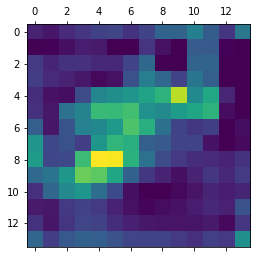

In [46]:
heatmap =  np.maximum(heatmap,0)
heatmap /= np.max(heatmap)

import matplotlib.pyplot as pyplt
pyplt.matshow(heatmap)

In [51]:
''' Use the OpenCV library for image read, write and display!
Use the function cv2.imshow() to display an image in a window. The window automatically fits to the image size.
In order to import cv2 correctly, I installed as follows in mlenv:
pip install opencv-contrib-python
However, the following never worked on my Ubuntu machine:  pip install opencv 
'''
import cv2

cv2.imread(img_path)
print('img.size: ', img.size)
heatmap = cv2.resize(heatmap, (img.size[1], img.size[0]))
heatmap = np.uint8(255 * heatmap) # scale every color of every pixel by 255
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img
#pyplt.matshow(superimposed_img)
#plt.imshow(heatmap)

superimposed_grad_img_path ='/home/sbradley/tensorflow/mlenv/chollet_book/images/heat-map-loss-grad-african-elephant-img.jpg'
cv2.imwrite(superimposed_grad_img_path, superimposed_img)


img.size:  (224, 224)


True